# Práctica No. 3   Teletransportación Cuántica y Mitigación de Errores

**Mateo Hoyos Mesa**  
**Sebastián López Dorado**

Computación Cuántica, Facultad de Ingeniería
Universidad de Antioquia, 2025


## Implementación del estado asignado

In [704]:
import math
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from qiskit.transpiler import generate_preset_pass_manager

In [705]:
# Hoyos - Kuhn
alpha = np.sqrt(0.7)
beta = np.sqrt(0.3) * np.exp(1j * 3 * np.pi / 4)

In [706]:
qubits = QuantumRegister(1, name='qubit') 
medida = ClassicalRegister(1, name='medida')
qc = QuantumCircuit(qubits, medida)
qc.initialize([alpha, beta], 0)

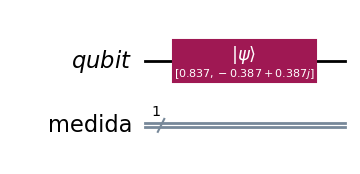

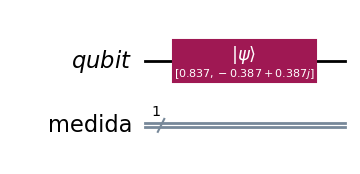

In [707]:
qc.draw(output='mpl')

## Diseño e implementación de Circuito Cuántico

In [708]:
%matplotlib inline
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

from qiskit.quantum_info import Statevector, random_statevector

from qiskit.visualization import plot_distribution, plot_bloch_multivector
from qiskit.visualization import array_to_latex

from qiskit_aer import AerSimulator
from numpy import pi

<IPython.core.display.Latex object>

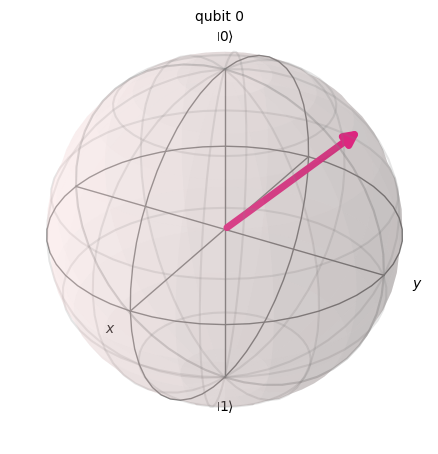

Las probabilidades de este estado cuántico aleatorio son: [0.82608312 0.17391688]


In [709]:
# Definición de un estado cuántico aleatorio de entrada para ser teletransportado
qrandom = random_statevector(2)
display(array_to_latex(Statevector(qrandom), prefix="\\ket{\\psi} = "))

fig = plot_bloch_multivector(Statevector(qrandom))
plt.show()

print("Las probabilidades de este estado cuántico aleatorio son:", Statevector(qrandom).probabilities())

In [710]:
# Definición de funciones para implementar las diversas etapas del circuito de teletransportación cuántica
def crear_estadoW(qc, a, b, c):
    qc.ry(1.9106332362490184, a)
    qc.cu(pi / 2, pi / 2, pi / 2, pi / 2, a, b)
    qc.cx(b, c)
    qc.cx(a, b)
    qc.x(a)
    
def circuito_de_alice(qc, q2send, beta0):
    qc.cx(q2send, beta0)
    qc.h(q2send)
    

def medicion_de_charlie(qc, c, crt):
    qc.barrier()
    qc.measure(c, crt)
    qc.barrier()

                    #(teleport_cir,Q2teletransport, QEntanglem_A, QEntanglem_B,crt,crz,crx)
def circuito_de_charlie(qc, QEntanglem_A, qubit_bob, Q2teletransport, m_charlie, m_alice1, m_alice2):
    with qc.if_test((m_charlie, 0)):  # Solo si Charlie midió |0⟩
        medicion_de_alice(qc, Q2teletransport, QEntanglem_A, m_alice2, m_alice1)
        circuito_de_bob(qc, qubit_bob, m_alice2, m_alice1)
        
def medicion_de_alice(qc, a, b, crz, crx):
    qc.measure(a, crz)
    qc.measure(b, crx)
    qc.barrier()
    qc.barrier()
            

def circuito_de_bob(qc, beta1, m1, m2):
    # Bob usa los bits clásicos para aplicar compuertas de manera condicional
    with qc.if_test((m2, 1)):
        qc.z(beta1)
    with qc.if_test((m1, 0)):
        qc.x(beta1)
        
        
def recuperar_en_alice(qc, q2send, qubitA):
    """
    Recupera el estado original en qubit t si Charlie midió |1⟩
    """
    qc.h(q2send)
    qc.cx(q2send, qubitA)


In [711]:
# Definición de registros de qubits de entrada
QEntanglem_A = QuantumRegister(1, name='Qubit_A')
QEntanglem_B = QuantumRegister(1, name='Qubit_B')
QEntanglem_C = QuantumRegister(1, name='Qubit_C')
Q2teletransport = QuantumRegister(1, name='Qubit_t')

# Definición de registros de bits clásicos para medida
crz = ClassicalRegister(1, name='crz')
crx = ClassicalRegister(1, name='crx')
crt = ClassicalRegister(1, name='crt')
crbob = ClassicalRegister(1, name='crbob')

# Definición del circuito de teletransportación cuántica
teleport_cir = QuantumCircuit(Q2teletransport, QEntanglem_A, QEntanglem_B, QEntanglem_C, crx, crz, crt, crbob)

In [712]:
# Ensamblado del circuito completo de la Teletransportación Cuántica
init_gate = QuantumCircuit(1, name="Random Input") 
init_gate.initialize(qrandom,0)
teleport_cir.append(init_gate.to_instruction(), Q2teletransport)
teleport_cir.barrier() 

crear_estadoW(teleport_cir, QEntanglem_A, QEntanglem_B, QEntanglem_C)
teleport_cir.barrier()

circuito_de_alice(teleport_cir, Q2teletransport, QEntanglem_A)

medicion_de_charlie(teleport_cir,QEntanglem_C,crt)

with teleport_cir.if_test((crt, 0)):  # Solo si Charlie midió |0⟩
        #medicion_de_alice(teleport_cir, Q2teletransport, QEntanglem_A, crx, crz)
        medicion_de_alice(teleport_cir, Q2teletransport, QEntanglem_A, crz, crx)
#                    t                A             t → crz, A → crx

        #circuito_de_bob(teleport_cir, QEntanglem_B, crx, crz)
        circuito_de_bob(teleport_cir, QEntanglem_B, crz, crx)
#                                     m1=t     m2=A


#with teleport_cir.if_test((crt, 1)):  # Si Charlie midió |1⟩
#    recuperar_en_alice(teleport_cir, Q2teletransport, QEntanglem_A)
    
with teleport_cir.if_test((crz, 0)):  
          teleport_cir.cy(Q2teletransport, QEntanglem_B)
          
with teleport_cir.if_test((crz, 1)):  
          teleport_cir.crz(pi, Q2teletransport, QEntanglem_B)
        


In [713]:
# Definición de simuladores requeridos
statevector_simulator = AerSimulator(method='statevector')
circuit_simulator = AerSimulator()

In [714]:
# Simulación del Vector de Estado a la salida del circuito
teleport_cir_statevector = teleport_cir.copy()
teleport_cir_statevector.save_statevector()

In [715]:
# Transpilación para posteriormente realizar la simulación del vector de estado resultante
circ_statevector = transpile(teleport_cir_statevector, statevector_simulator)

# Ejecución y obtención del statevector
result = statevector_simulator.run(circ_statevector).result()
statevector = result.get_statevector(circ_statevector)

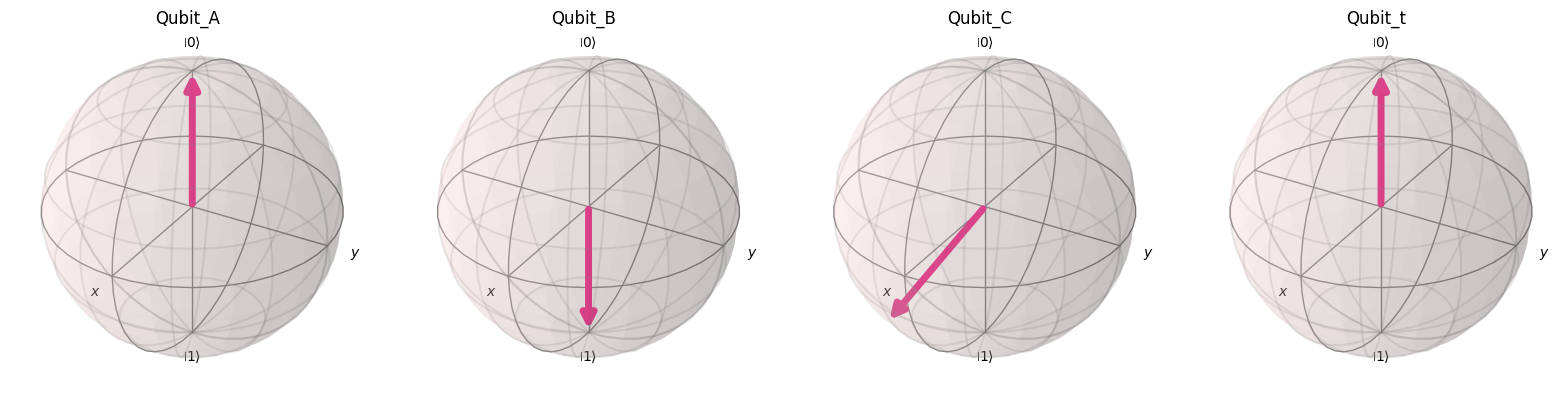

<IPython.core.display.Latex object>

In [716]:
fig = plot_bloch_multivector(statevector)

custom_labels = ['Qubit_A', 'Qubit_B', 'Qubit_C','Qubit_t']
for ax, label in zip(fig.axes, custom_labels):
    ax.set_title(label, pad=28)
plt.show()

display(array_to_latex(Statevector(statevector), prefix="\\ket{Salida_{statevector}} = "))

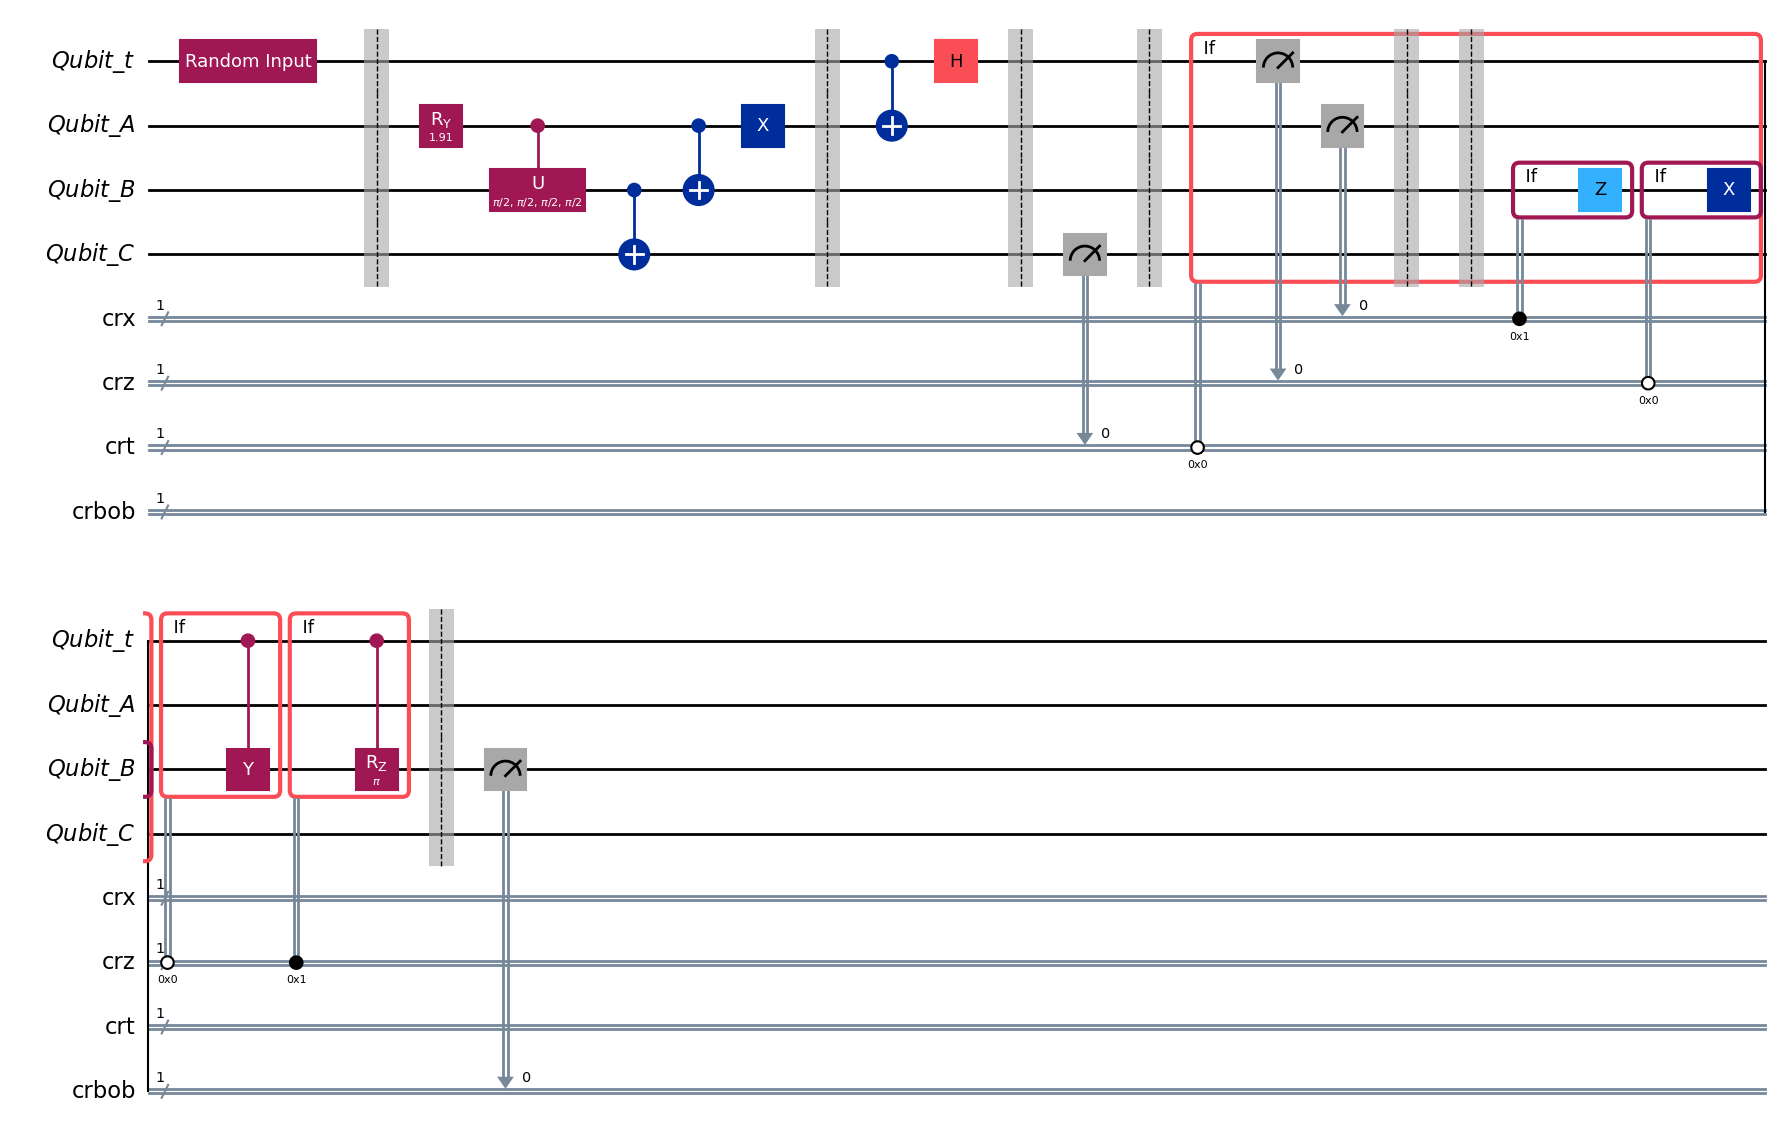

In [717]:
teleport_cir.barrier() # Uso de "barrier" (barrera) para separar las diversas etapas
teleport_cir.measure(QEntanglem_B, crbob)

teleport_cir.draw('mpl')
plt.show()

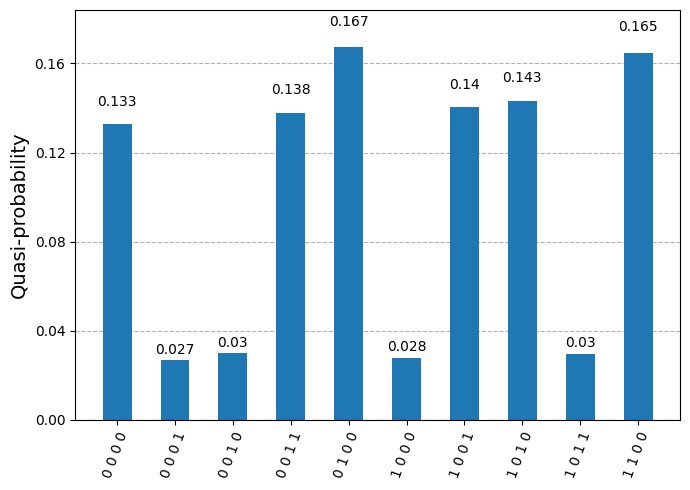

In [718]:
# Simulación del circuito completo
shots = 8192
teleport_result = circuit_simulator.run(teleport_cir.decompose(reps=1), shots=shots).result()
data = teleport_result.get_counts(teleport_cir)

plot_distribution(data)
# En este conjunto de datos de probabilidad está todo el universo del circuito. 
# Los qubits q0 y q1 corresponden a los obtenidos por Alice antes de la medida.
# Y el qubit q2 corresponde al recibido por Bob. 
plt.show()

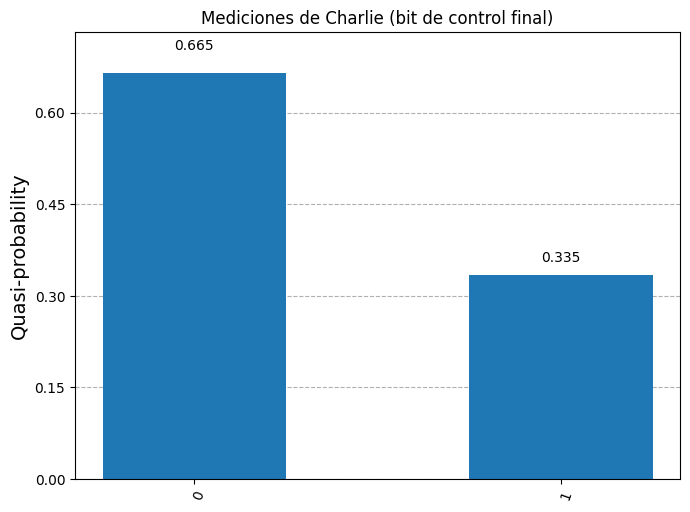

In [719]:
charlie = {'0': 0, '1': 0}

for key, count in data.items():
    # El bit de Charlie es el ÚLTIMO (posición -1)
    bit_charlie = key[-1]
    if bit_charlie == '0':
        charlie['0'] += count
    else:
        charlie['1'] += count

plot_distribution(charlie)
plt.title("Mediciones de Charlie (bit de control final)")
plt.show()


In [720]:
from qiskit.quantum_info import partial_trace, Statevector, state_fidelity

# Obtener la traza parcial del qubit de Bob (índice 2 si ordenas [t, A, B, C])
rho_bob = partial_trace(statevector, [0, 1, 3])  # elimina todos excepto Bob

# Fidelidad con el estado original aleatorio
fidelidad = state_fidelity(rho_bob, qrandom)

print("Fidelidad entre el estado enviado y el recibido por Bob:", fidelidad)


Fidelidad entre el estado enviado y el recibido por Bob: 0.047629307048144845


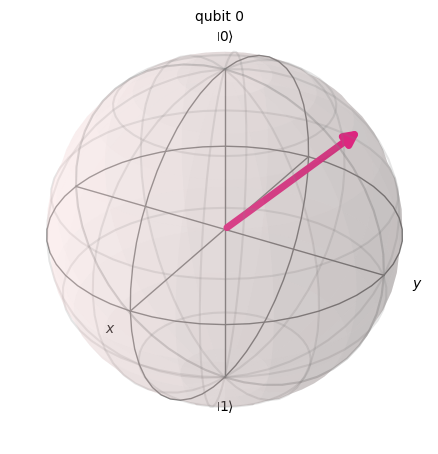

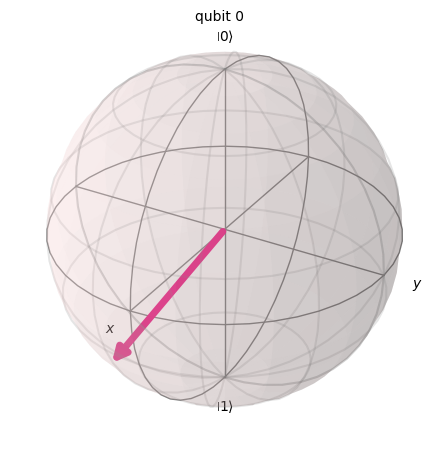

In [721]:
plot_bloch_multivector(qrandom)
plot_bloch_multivector(rho_bob)
plt.show()